<a href="https://colab.research.google.com/github/gabrielcerono/TransplantAnalysis/blob/main/Transplante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import plotly.graph_objs as gobj
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
!pip install lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import sklearn as sk



     |████████████████████████████████| 348kB 6.6MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=97184fa581fac46173ec3d6c2a6e7f6f0e29e9748cf54971994abc61cd398386
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [ ]:
dataset = pd.read_excel("/content/transplant.xlsx")

In [ ]:
dataset.head(10)

,Patient,Age,Sex,Survival days after transplantation,Weight,Donor,Retrasplant,ABO compatibility,BUN,Creatinine,Glucose,Albumin,Protein,SGOT,SGPT,Total bilirubin,Unnamed: 16,K,CI,WBC,Hemoglobin,Hematocrit,Platelet
0,Kidney_mor_1,39,Female,73,45,Deceased,No,Identical,85.8,6.70,117,3.3,5.7,8.0,11.0,0.6,135.0,6.1,19.0,825.0,11.4,19.2,274
1,Kidney_mor_2,56,Male,46,65,Living,No,Identical,85.0,13.80,95,4.0,7.0,223.0,316.0,1.1,138.0,5.9,99.0,5.2,9.1,28.2,159
2,Kidney_mor_3,40,Male,9,52,Deceased,No,Identical,13.0,1.50,233,3.7,5.6,36.0,94.0,0.2,142.0,4.4,114.0,84.0,9.7,24.2,112
3,Kidney_mor_4,37,Male,17,51,Living,Yes,Compatible,48.0,1.30,88,3.3,6.5,21.0,12.0,0.4,138.0,4.9,99.0,519.0,9.7,29.0,164
4,Kidney_mor_5,67,Male,82,50,Deceased,Yes,Identical,64.0,11.90,11,4.4,6.7,1.0,12.0,1.2,142.0,5.9,17.0,38.0,8.8,31.1,144
5,Kidney_mor_6,45,Female,38,52,Deceased,No,Identical,9.0,12.50,72,4.6,6.7,24.0,19.0,0.4,143.0,5.8,13.0,52.0,9.0,26.8,14
6,Kidney_mor_7,67,Male,14,72,Deceased,No,Identical,85.0,11.46,141,2.9,5.8,23.0,11.0,0.4,136.0,4.1,14.0,534.0,1.4,26.6,123
7,Kidney_mor_8,49,Female,5,68,Deceased,No,Identical,66.6,8.98,89,5.0,7.5,17.0,23.0,0.3,14.0,4.8,113.0,73.0,1.7,28.9,14
8,Kidney_mor_9,55,Female,86,54,Deceased,No,Identical,72.5,8.50,192,4.2,7.6,13.0,9.0,0.3,137.8,6.2,13.6,798.0,1.2,33.6,15
9,Kidney_mor_10,61,Male,34,57,Living,No,Identical,34.0,9.60,11,4.0,7.3,14.0,9.0,0.5,132.0,4.5,91.0,66.0,11.0,25.0,256


# Background on the DataSet


This is a newly published dataset, for recently **Kidney Transplanted Patients** . All of these patients suffered from Treatment-related mortality (TRM), These are patients that passed away between the surgery and up to 3 months from it. We don't have a control group data from people that didn't suffer from TRM, but we could segment the Data between Short TRM and Long TRM, and treat it as a Classification problem. 

We don't have right censored data, so applying survival models is not obligatory. Nevertheless, I would like to introduce some models to practice.


Here, I leave a good paper about TRM:

[Paper about TRM](https://pubmed.ncbi.nlm.nih.gov/32722695/)

And here I leave the Dataset link from Harvard University:

[Link to the dataset](https://dataverse.harvard.edu/file.xhtml?fileId=4159133&version=2.0)

# Each Column Description



1.   **E -The weight** : is in Kilomgrams, 1 Kg = 2.2 lbs

2.   **Donor** - Kidneys can be taken either from a Living Donor, ussually a member of the family, spouse or really close friends. Diseased donors, are usually critically ill patients with a criteria of brain death. Kidney transplants that come from a Living donor usually have a better prognosis. 

3.   **Retransplant** : Patient that had a second transplant because lose of the first kidney transplant. 
4.  **ABO compability** : Blood groups A,B compability between the donor and the recipient. 


5.  **BUN** : Blood Urea Nitrogen - Along with creatinine is a measurement of kidney function. The higher it goes, the worse the kidney are functioning.

6.  **Creatinine**: Measurement of kidney function. You can compute BUN/Cretinine ratio to look for pre renal azotemia. (Kidneys stop working due to low blood pressure).

7.  **Glucose** : Glucose in blood, a measurement above 200 mg/dl often means a Diabetes diagnosis

8.  **Albumin - Protein** : A way to measure hepatic function, low numbers often mean, low hepatic function. Albumin and protein can also be low due to a Nephrotic syndrome. (Losing protein in the urine) 

9.   **SGOT	SGPT**: These are transminases, they are elevated during liver cell injury. 

10.  **Total Billirubin** : Measurement of bilirrubin in blod, damage or obstruction along the bile pathway may increase. 

11.  **Na, K, CL** : Electrolytes in the blood, a lot of things may cause a change on these one.

12.   **Hemoglobin and Hematocrit** : Measurement of erytrocites. Aneamia is usually diagnosed with < 13 mg/dl in men and < 12mg/dl in woman.

13.  **Platelets**: Low platelets increases the chance of bleeding. regular levels are around 200-400 thousands. 


# Action Plan


The plan is to build a model, that can stratify the risk of a patient after transplant surgery. Treatment can then be adjusted depending on the risk of dying during the first 30 days or not.  

# Let's start with the classification problem




Okay, Let's make 2 columns classifying the TRM between early and late. Let's drop the first row 

In [ ]:
dataset.columns

Index(['Patient', 'Age', 'Sex', 'Survival days after transplantation',
       'Weight', 'Donor', 'Retrasplant', 'ABO compatibility', 'BUN',
       'Creatinine', 'Glucose ', 'Albumin', 'Protein', 'SGOT', 'SGPT',
       ' Total bilirubin', 'Unnamed: 16', 'K', 'CI', 'WBC', 'Hemoglobin',
       'Hematocrit', 'Platelet'],
      dtype='object')

In [ ]:
dataset.head(20)

,Patient,Age,Sex,Survival days after transplantation,Weight,Donor,Retrasplant,ABO compatibility,BUN,Creatinine,Glucose,Albumin,Protein,SGOT,SGPT,Total bilirubin,Unnamed: 16,K,CI,WBC,Hemoglobin,Hematocrit,Platelet
0,Kidney_mor_1,39,Female,73,45,Deceased,No,Identical,85.8,6.70,117,3.30,5.7,8.0,11.0,0.60,135.0,6.1,19.0,825.0,11.4,19.2,274
1,Kidney_mor_2,56,Male,46,65,Living,No,Identical,85.0,13.80,95,4.00,7.0,223.0,316.0,1.10,138.0,5.9,99.0,5.2,9.1,28.2,159
2,Kidney_mor_3,40,Male,9,52,Deceased,No,Identical,13.0,1.50,233,3.70,5.6,36.0,94.0,0.20,142.0,4.4,114.0,84.0,9.7,24.2,112
3,Kidney_mor_4,37,Male,17,51,Living,Yes,Compatible,48.0,1.30,88,3.30,6.5,21.0,12.0,0.40,138.0,4.9,99.0,519.0,9.7,29.0,164
4,Kidney_mor_5,67,Male,82,50,Deceased,Yes,Identical,64.0,11.90,11,4.40,6.7,1.0,12.0,1.20,142.0,5.9,17.0,38.0,8.8,31.1,144
5,Kidney_mor_6,45,Female,38,52,Deceased,No,Identical,9.0,12.50,72,4.60,6.7,24.0,19.0,0.40,143.0,5.8,13.0,52.0,9.0,26.8,14
6,Kidney_mor_7,67,Male,14,72,Deceased,No,Identical,85.0,11.46,141,2.90,5.8,23.0,11.0,0.40,136.0,4.1,14.0,534.0,1.4,26.6,123
7,Kidney_mor_8,49,Female,5,68,Deceased,No,Identical,66.6,8.98,89,5.00,7.5,17.0,23.0,0.30,14.0,4.8,113.0,73.0,1.7,28.9,14
8,Kidney_mor_9,55,Female,86,54,Deceased,No,Identical,72.5,8.50,192,4.20,7.6,13.0,9.0,0.30,137.8,6.2,13.6,798.0,1.2,33.6,15
9,Kidney_mor_10,61,Male,34,57,Living,No,Identical,34.0,9.60,11,4.00,7.3,14.0,9.0,0.50,132.0,4.5,91.0,66.0,11.0,25.0,256


In [ ]:
def one_hot_encode(df, column):
    one_hot = pd.get_dummies(df[column], prefix=column)
    df = df.drop(column, axis = 1)
    df = df.join(one_hot)
    print(one_hot.columns)
    return df
def lookup_encode(df, column, lookup):
    df[column] = df[column].map(lookup)
    return df

dataset = one_hot_encode(dataset, 'ABO compatibility')
dataset = one_hot_encode(dataset, 'Donor')
dataset = lookup_encode(dataset, 'Sex', lambda x: 1 if x == 'Male' else 0)
dataset = lookup_encode(dataset, 'Retrasplant', lambda x: 1 if x in [1, '1', 'Yes'] else 0)

Index(['ABO compatibility_Compatible', 'ABO compatibility_Identical',
       'ABO compatibility_Incompatible'],
      dtype='object')
Index(['Donor_Deceased', 'Donor_Living', 'Donor_Non-heart beating'], dtype='object')


In [ ]:
dataset.head()

,Patient,Age,Sex,Survival days after transplantation,Weight,Retrasplant,BUN,Creatinine,Glucose,Albumin,Protein,SGOT,SGPT,Total bilirubin,Unnamed: 16,K,CI,WBC,Hemoglobin,Hematocrit,Platelet,ABO compatibility_Compatible,ABO compatibility_Identical,ABO compatibility_Incompatible,Donor_Deceased,Donor_Living,Donor_Non-heart beating
0,Kidney_mor_1,39,0,73,45,0,85.8,6.7,117,3.3,5.7,8.0,11.0,0.6,135.0,6.1,19.0,825.0,11.4,19.2,274,0,1,0,1,0,0
1,Kidney_mor_2,56,1,46,65,0,85.0,13.8,95,4.0,7.0,223.0,316.0,1.1,138.0,5.9,99.0,5.2,9.1,28.2,159,0,1,0,0,1,0
2,Kidney_mor_3,40,1,9,52,0,13.0,1.5,233,3.7,5.6,36.0,94.0,0.2,142.0,4.4,114.0,84.0,9.7,24.2,112,0,1,0,1,0,0
3,Kidney_mor_4,37,1,17,51,1,48.0,1.3,88,3.3,6.5,21.0,12.0,0.4,138.0,4.9,99.0,519.0,9.7,29.0,164,1,0,0,0,1,0
4,Kidney_mor_5,67,1,82,50,1,64.0,11.9,11,4.4,6.7,1.0,12.0,1.2,142.0,5.9,17.0,38.0,8.8,31.1,144,0,1,0,1,0,0


# Next Step Should be an EDA

In [ ]:
corr_matrix = dataset.corr()
corr_matrix["Survival days after transplantation"].sort_values(ascending=False)

Survival days after transplantation    1.000000
K                                      0.052202
ABO compatibility_Identical            0.046546
Albumin                                0.026723
Donor_Living                           0.009639
Protein                                0.002891
Donor_Deceased                        -0.004207
CI                                    -0.007737
Glucose                               -0.009201
Hematocrit                            -0.014441
WBC                                   -0.019031
Hemoglobin                            -0.025998
Retrasplant                           -0.027839
ABO compatibility_Incompatible        -0.028322
Platelet                              -0.028917
 Total bilirubin                      -0.030735
ABO compatibility_Compatible          -0.032226
Age                                   -0.035401
SGOT                                  -0.038450
BUN                                   -0.041151
Creatinine                            -0

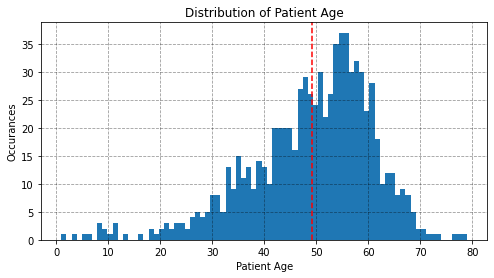

In [ ]:
age_sorted = np.sort(dataset['Age'])
average_age = np.mean(dataset['Age'])

fig, ax = plt.subplots(1, figsize=(8, 4))

plt.hist(dataset['Age'], bins=int(dataset['Age'].max()))
plt.axvline(np.mean(dataset['Age']), c='r', ls='--')

ax.set_xlabel('Patient Age')
ax.set_ylabel('Occurances')
ax.set_title('Distribution of Patient Age')

ax.grid(c='k', ls='--', alpha=.4)
plt.savefig('distribution_of_patient_age.png')
plt.show()

# Pediatric Transplants

Kidney transplant in pediatric suffer from different complications than AKT, that's why I am droping all of the patients with less than 20 yo. 

Source: [Pediatric kidney transplantation is different from adult kidney transplantation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6106688/)

In [ ]:
dataset_adult = dataset.loc[dataset['Age'] > 20]

In [ ]:
dataset_adult.shape

(783, 27)

# Kaplan Meier Survival Stimator

We will need to creater another column, where all the values are 1, so to represent that all of the patients died

In [ ]:
dataset['observed'] = [1 if x > 0 else 0 for x in dataset["Survival days after transplantation"]] 

In [ ]:
kmf = KaplanMeierFitter()
T = dataset["Survival days after transplantation"]
E = dataset["observed"]

kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 803 total observations, 8 right-censored observations>

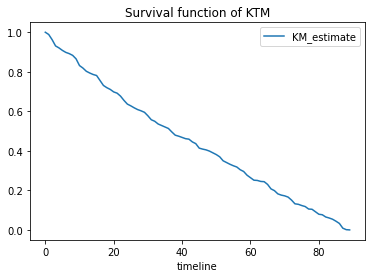

In [ ]:
kmf.survival_function_.plot()
plt.title('Survival function of KTM');

# Survival Fit trees

In [ ]:
!pip install scikit-survival



In [ ]:
y = dataset[["observed", "Survival days after transplantation"]]
X = dataset[dataset.columns.difference(['Survival days after transplantation', 'observed'])]


In [ ]:
X = X.drop("Patient", axis= 1)

In [ ]:
y['observed'] = y['observed'].astype('bool')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.25)


In [ ]:
y.head()

,observed,Survival days after transplantation
149,True,61
603,True,87
310,True,2
697,True,2
720,True,54


In [ ]:
y = y.to_records(index= False)


In [ ]:
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=12)

In [ ]:
rsf.fit(X, y)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=15,
                     min_samples_split=10, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=12, verbose=0, warm_start=False)

In [ ]:
y_test = y_test.to_records(index = False)

In [ ]:
rsf.score(X_test, y_test)

0.48592685084022685

# Deep Survival

In [ ]:
pip install pycox

     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [ ]:
X.head()

,Total bilirubin,ABO compatibility_Compatible,ABO compatibility_Identical,ABO compatibility_Incompatible,Age,Albumin,BUN,CI,Creatinine,Donor_Deceased,Donor_Living,Donor_Non-heart beating,Glucose,Hematocrit,Hemoglobin,K,Platelet,Protein,Retrasplant,SGOT,SGPT,Sex,Unnamed: 16,WBC,Weight
642,0.30,0,1,0,56,4.1,56.0,11.0,13.8,0,1,0,12,34.2,9.8,4.0,184,7.7,0,23.0,19.0,0,141.0,66.0,49
498,0.18,1,0,0,48,3.8,61.7,19.0,7.3,0,1,0,79,28.7,12.9,4.8,252,5.9,0,23.0,27.0,0,136.0,61.0,49
753,0.40,0,1,0,51,4.0,6.0,12.0,1.6,0,1,0,118,32.8,13.2,4.2,259,6.8,0,13.0,22.0,0,141.0,39.0,53
179,0.50,0,1,0,50,4.4,55.5,113.0,5.2,1,0,0,93,37.0,12.1,6.1,212,6.8,0,16.0,14.0,1,143.0,452.0,68
776,1.20,0,1,0,33,3.7,55.5,98.0,7.4,0,1,0,86,28.9,12.0,4.7,383,5.5,0,17.0,22.0,1,14.0,16.0,88


In [ ]:
X.columns

Index([' Total bilirubin', 'ABO compatibility_Compatible',
       'ABO compatibility_Identical', 'ABO compatibility_Incompatible', 'Age',
       'Albumin', 'BUN', 'CI', 'Creatinine', 'Donor_Deceased', 'Donor_Living',
       'Donor_Non-heart beating', 'Glucose ', 'Hematocrit', 'Hemoglobin', 'K',
       'Platelet', 'Protein', 'Retrasplant', 'SGOT', 'SGPT', 'Sex',
       'Unnamed: 16', 'WBC', 'Weight'],
      dtype='object')

In [ ]:
cols_standardize = [' Total bilirubin', 'Age', 'Albumin', 'BUN', 'CI', 'Creatinine', 'Hematocrit', 'Hemoglobin', 'Glucose ', 'K', 'Platelet', 'Protein', 'SGOT', 'SGPT', 'Unnamed: 16', 'WBC', 'Weight']
cols_leave = ['ABO compatibility_Identical', 'ABO compatibility_Incompatible', 'Donor_Deceased', 'Donor_Living','Donor_Non-heart beating', 'Sex', 'Retrasplant']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)


In [ ]:
X = x_mapper.fit_transform(X).astype('float32')
X_test = x_mapper.transform(X_test).astype('float32')


In [ ]:
get_target = lambda y: (y['Survival days after transplantation'].values, y['observed'].values)
y_train = get_target(y)
y_val = get_target(y_test)
durations_test, events_test = get_target(y_test)
val = X_test, y_val

In [ ]:
in_features = X.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [ ]:
from pycox.models import CoxPH

In [ ]:
model = CoxPH(net, tt.optim.Adam)

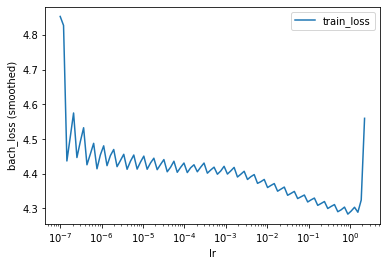

In [ ]:
batch_size = 256
lrfinder = model.lr_finder(X, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [ ]:
model.optimizer.set_lr(0.01)

In [ ]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [ ]:
%%time
log = model.fit(X, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.3790,	val_loss: 4.3535
1:	[0s / 0s],		train_loss: 4.2327,	val_loss: 4.3704
2:	[0s / 0s],		train_loss: 4.2205,	val_loss: 4.3820
3:	[0s / 0s],		train_loss: 4.1960,	val_loss: 4.3825
4:	[0s / 0s],		train_loss: 4.1992,	val_loss: 4.3822
5:	[0s / 0s],		train_loss: 4.1824,	val_loss: 4.3651
6:	[0s / 0s],		train_loss: 4.1735,	val_loss: 4.3513
7:	[0s / 0s],		train_loss: 4.1546,	val_loss: 4.3483
8:	[0s / 0s],		train_loss: 4.1431,	val_loss: 4.3511
9:	[0s / 0s],		train_loss: 4.1557,	val_loss: 4.3517
10:	[0s / 0s],		train_loss: 4.1518,	val_loss: 4.3502
11:	[0s / 0s],		train_loss: 4.1472,	val_loss: 4.3555
12:	[0s / 0s],		train_loss: 4.1325,	val_loss: 4.3695
13:	[0s / 0s],		train_loss: 4.1049,	val_loss: 4.3819
14:	[0s / 0s],		train_loss: 4.1133,	val_loss: 4.3837
15:	[0s / 0s],		train_loss: 4.1087,	val_loss: 4.3891
16:	[0s / 0s],		train_loss: 4.0949,	val_loss: 4.3903
17:	[0s / 0s],		train_loss: 4.0789,	val_loss: 4.3898
CPU times: user 280 ms, sys: 9.48 ms, total: 289 ms
Wall

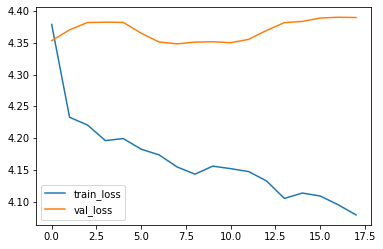

In [ ]:
_ = log.plot()